# K-neighbors: Wine dataset
[UCI Machine learning](https://archive.ics.uci.edu/dataset/109/wine)
## Codice di esecuzione
### Caricamento dati

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import *

df = load_wine_data()
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

### K-Neighbors

nel file testing ho fatto una serie di analisi, quindi:
- andiamo a cazzo duro dritti sul uno StandardScaler. 
- Mi aspettere un k tra 3 e 5 (non certo 18)
- Attenzione che secondo me hai confuso gli score

Approccio
1. Scaliamo
2. K-neighborn con loop normale, calcoliamo 
    - Elbow
    - Silhouette
3. Dopo pensiamo a GridSearch

#### Senza Cross Validation

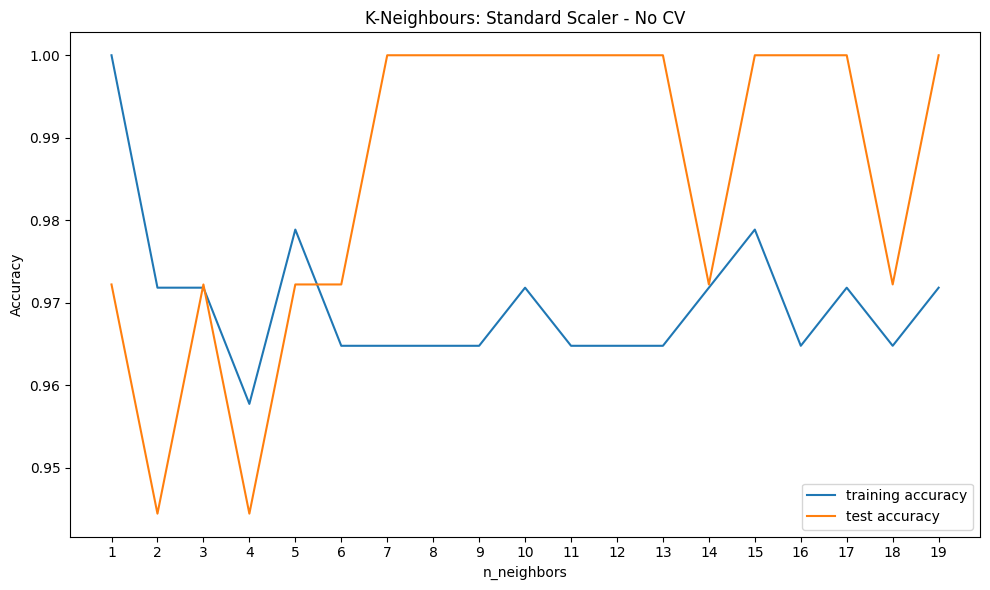

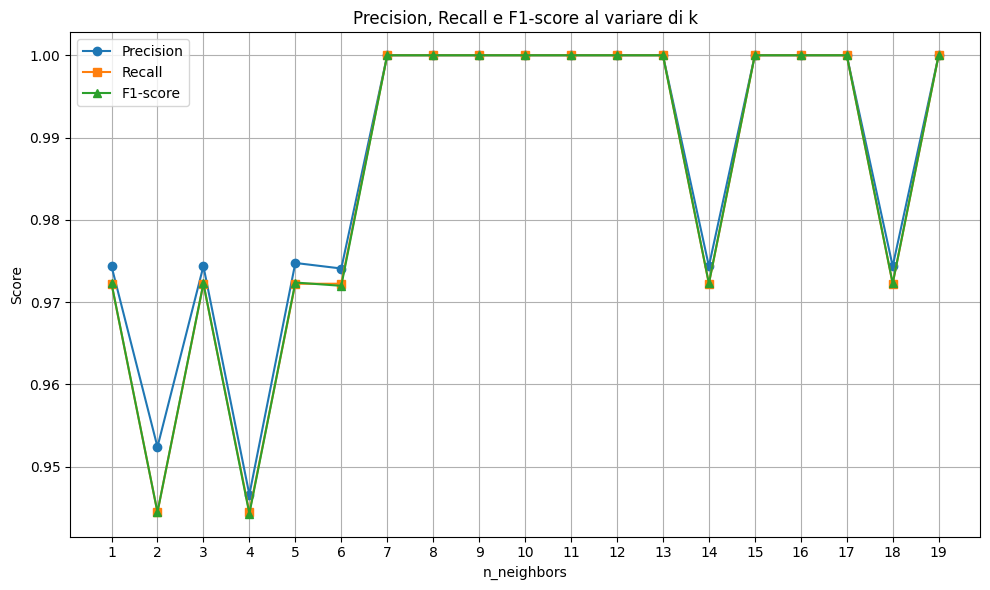

In [15]:
# DIVISIONE TRAIN TEST
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# NORMALIZZAZIONE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)                   # Calcolo parametri di scaling e normalizzazione    
X_test_ss = scaler.transform(X_test)                         # Normalizzazione del test set con i parametri del train set           

# K-Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = np.arange(1, 20)

training_accuracy = []
test_accuracy = []

precision_scores = []
recall_scores = []
f1_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_ss, y_train)
    y_pred = knn.predict(X_test_ss)
    
    # ACCURATEZZA DI TEST E DI TRAINING
    training_accuracy.append(knn.score(X_train_ss, y_train))            # knn.score => Accuratezza
    test_accuracy.append(knn.score(X_test_ss, y_test))                  # knn.score => Accuratezza

    # Precision, Recall, F1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')    
    # Salvataggio dei valori
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Matrice di confusione per ogni k
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Matrice di Confusione per k={k}")
    plt.savefig(rf"chart\confusion_matrix_k_{k}.png")
    plt.close()
    
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_values, training_accuracy, label="training accuracy")
ax.plot(k_values, test_accuracy, label="test accuracy")

plt.xticks(k_values)
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.title("K-Neighbours: Standard Scaler - No CV")
plt.xticks(k_values)
plt.savefig(r"chart\accuracy.png")
plt.tight_layout()
plt.show()
plt.close()

# Grafico delle metriche
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_scores, marker='o', label='Precision')
plt.plot(k_values, recall_scores, marker='s', label='Recall')
plt.plot(k_values, f1_scores, marker='^', label='F1-score')
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.title("Precision, Recall e F1-score al variare di k")
plt.xticks(k_values)
plt.savefig(r"chart\Precision.png")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train_ss, y_train)
y_pred = knn.predict(X_test_ss)
    
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[12  0  0]
 [ 1 13  0]
 [ 0  0 10]]


#### Cross Validation

Miglior valore di K: 18


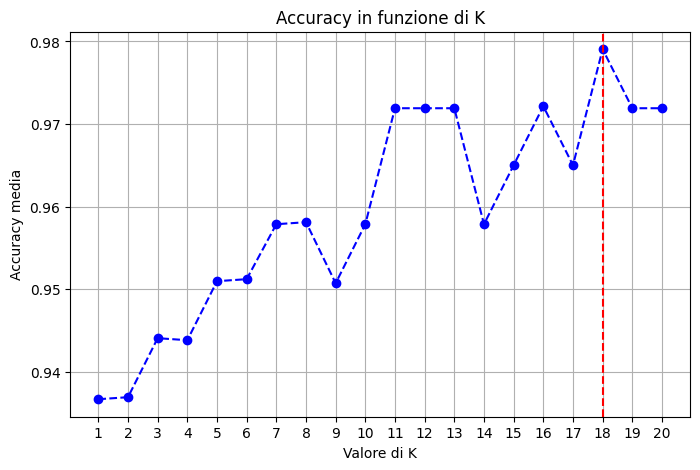

In [3]:
# TEST SU UN RANGE DI K PER VALUTARE IL K OTTIMALE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier              
param_grid = {'n_neighbors': np.arange(1, 21)}                                              # ParamGrid è un dizionario di parametri che vengono passati 
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')    # Esegue la ricerca con validazione incrociata
grid_search.fit(X_train_ss, y_train)                                                        # Addestra il modello con tutti i valori di K
best_k = grid_search.best_params_['n_neighbors']                                            # Ottiene il valore di K ottimale
print(f'Miglior valore di K: {best_k}')                                                     # Stampa il miglior valore di K

# PLOT ACCURACY PER K
k_values = np.arange(1, 21)
accuracies = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o', linestyle='dashed', color='b')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best K: {best_k}')
plt.xlabel('Valore di K')
plt.ylabel('Accuracy media')
plt.title('Accuracy in funzione di K')
plt.xticks(k_values)
plt.grid()
plt.show()

Faccio una serie di confusioni tra:
- il risultato (y_pred)
- accuracy
- score

#### Senza Cross Validation - Boundaries con PCA

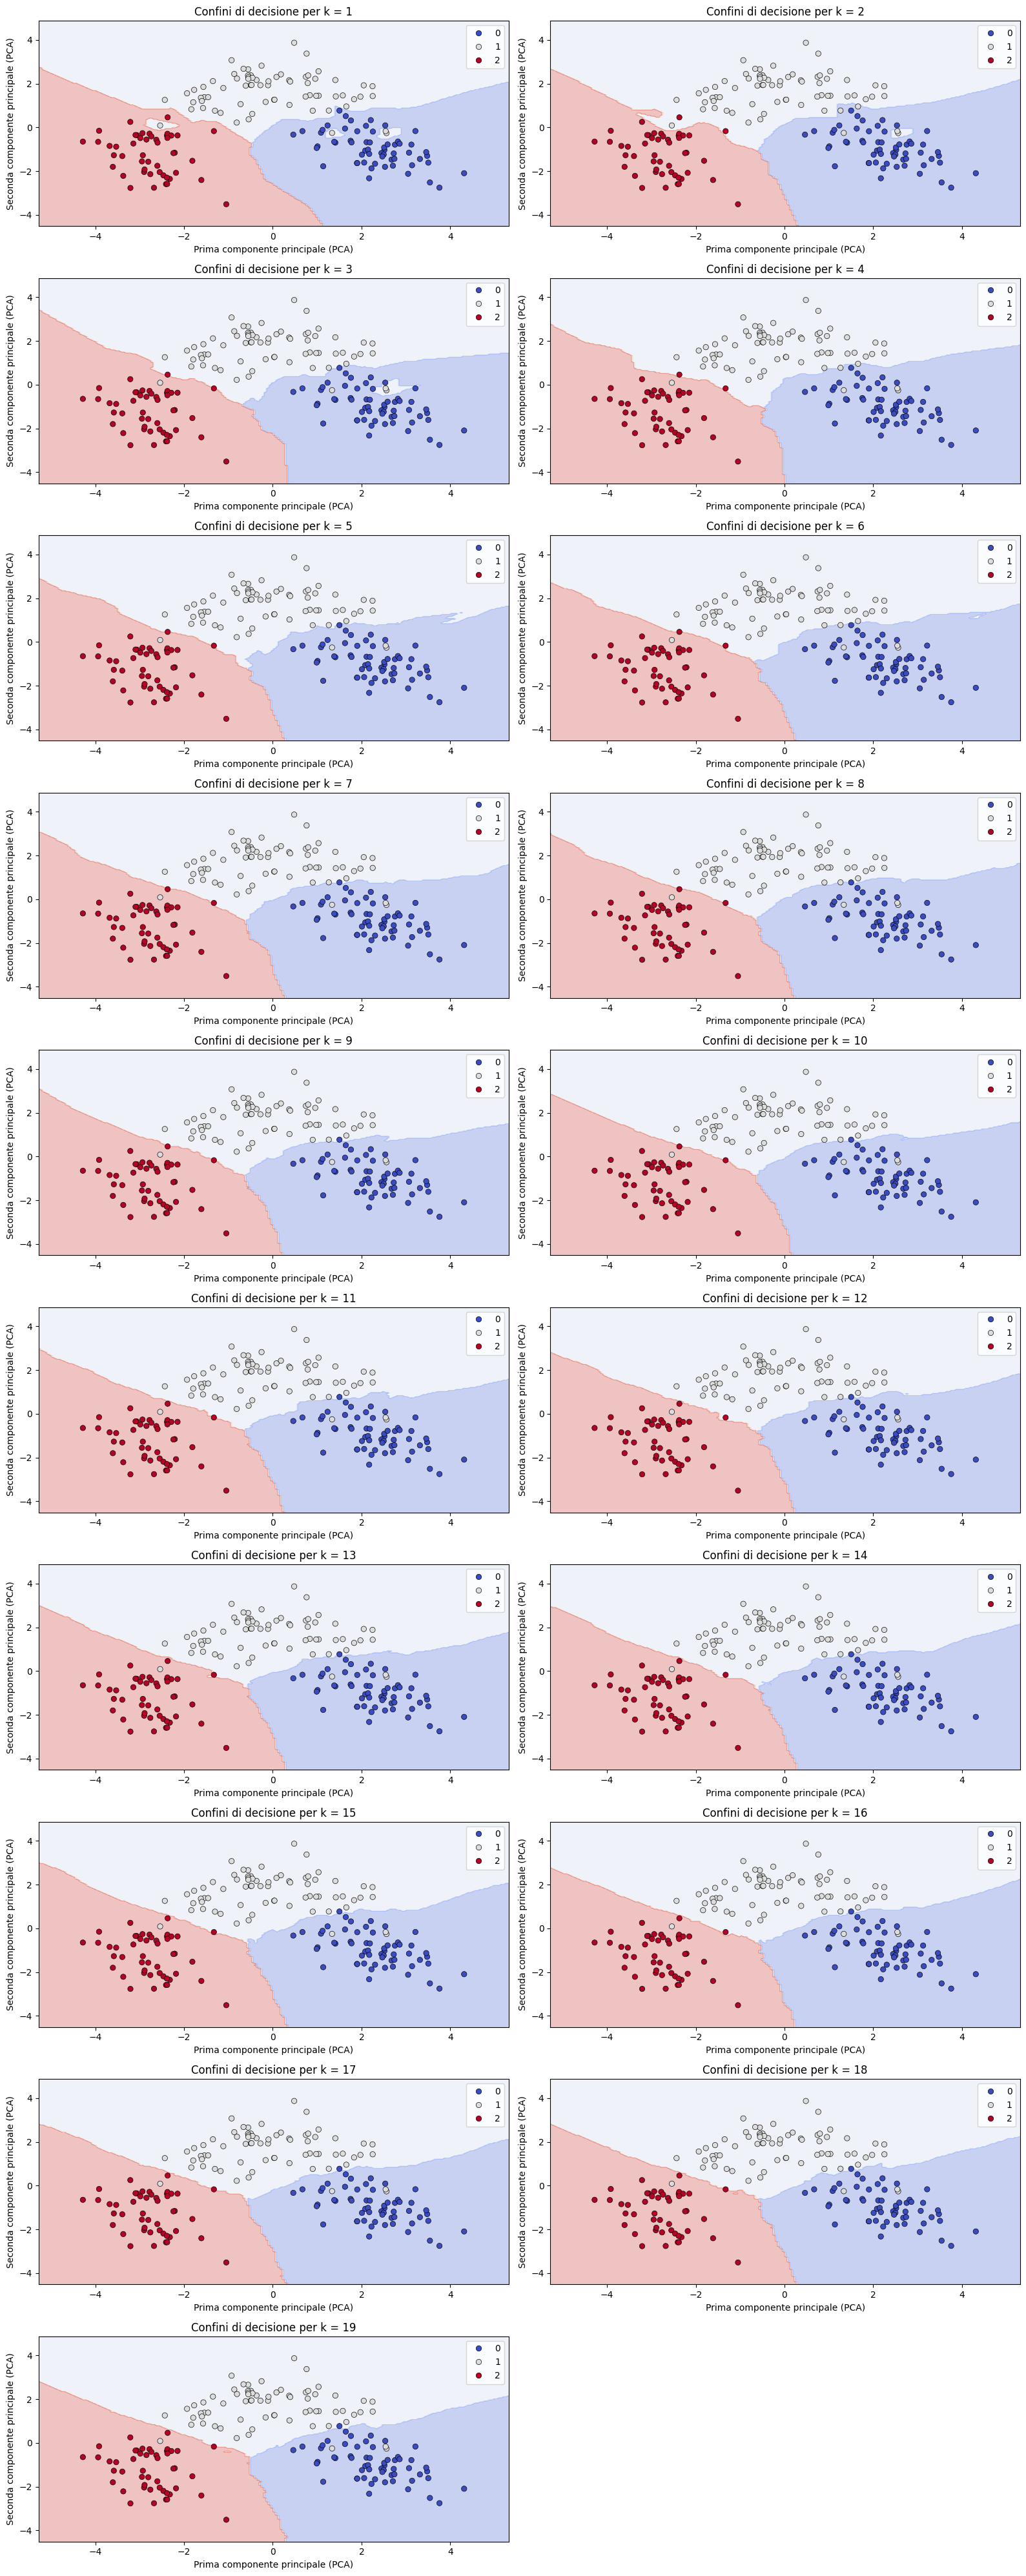

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine

# Caricamento dataset Wine
data = load_wine()
X = data.data
y = data.target

# Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Riduzione dimensionale con PCA (prendiamo solo 2 componenti per la visualizzazione)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Definiamo un range di valori di k da testare
k_values = np.arange(1,20)

# Creazione della griglia di punti per disegnare i confini di decisione
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Creazione del grafico per diversi valori di k
plt.figure(figsize=(16, 40))
for i, k in enumerate(k_values, 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pca, y)

    # Predizione per ogni punto della griglia
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Disegno dei confini di decisione
    plt.subplot(10, 2, i)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', edgecolor='k')

    plt.title(f"Confini di decisione per k = {k}")
    plt.xlabel("Prima componente principale (PCA)")
    plt.ylabel("Seconda componente principale (PCA)")

plt.tight_layout()
plt.show()


In [23]:
len(X_pca)

178

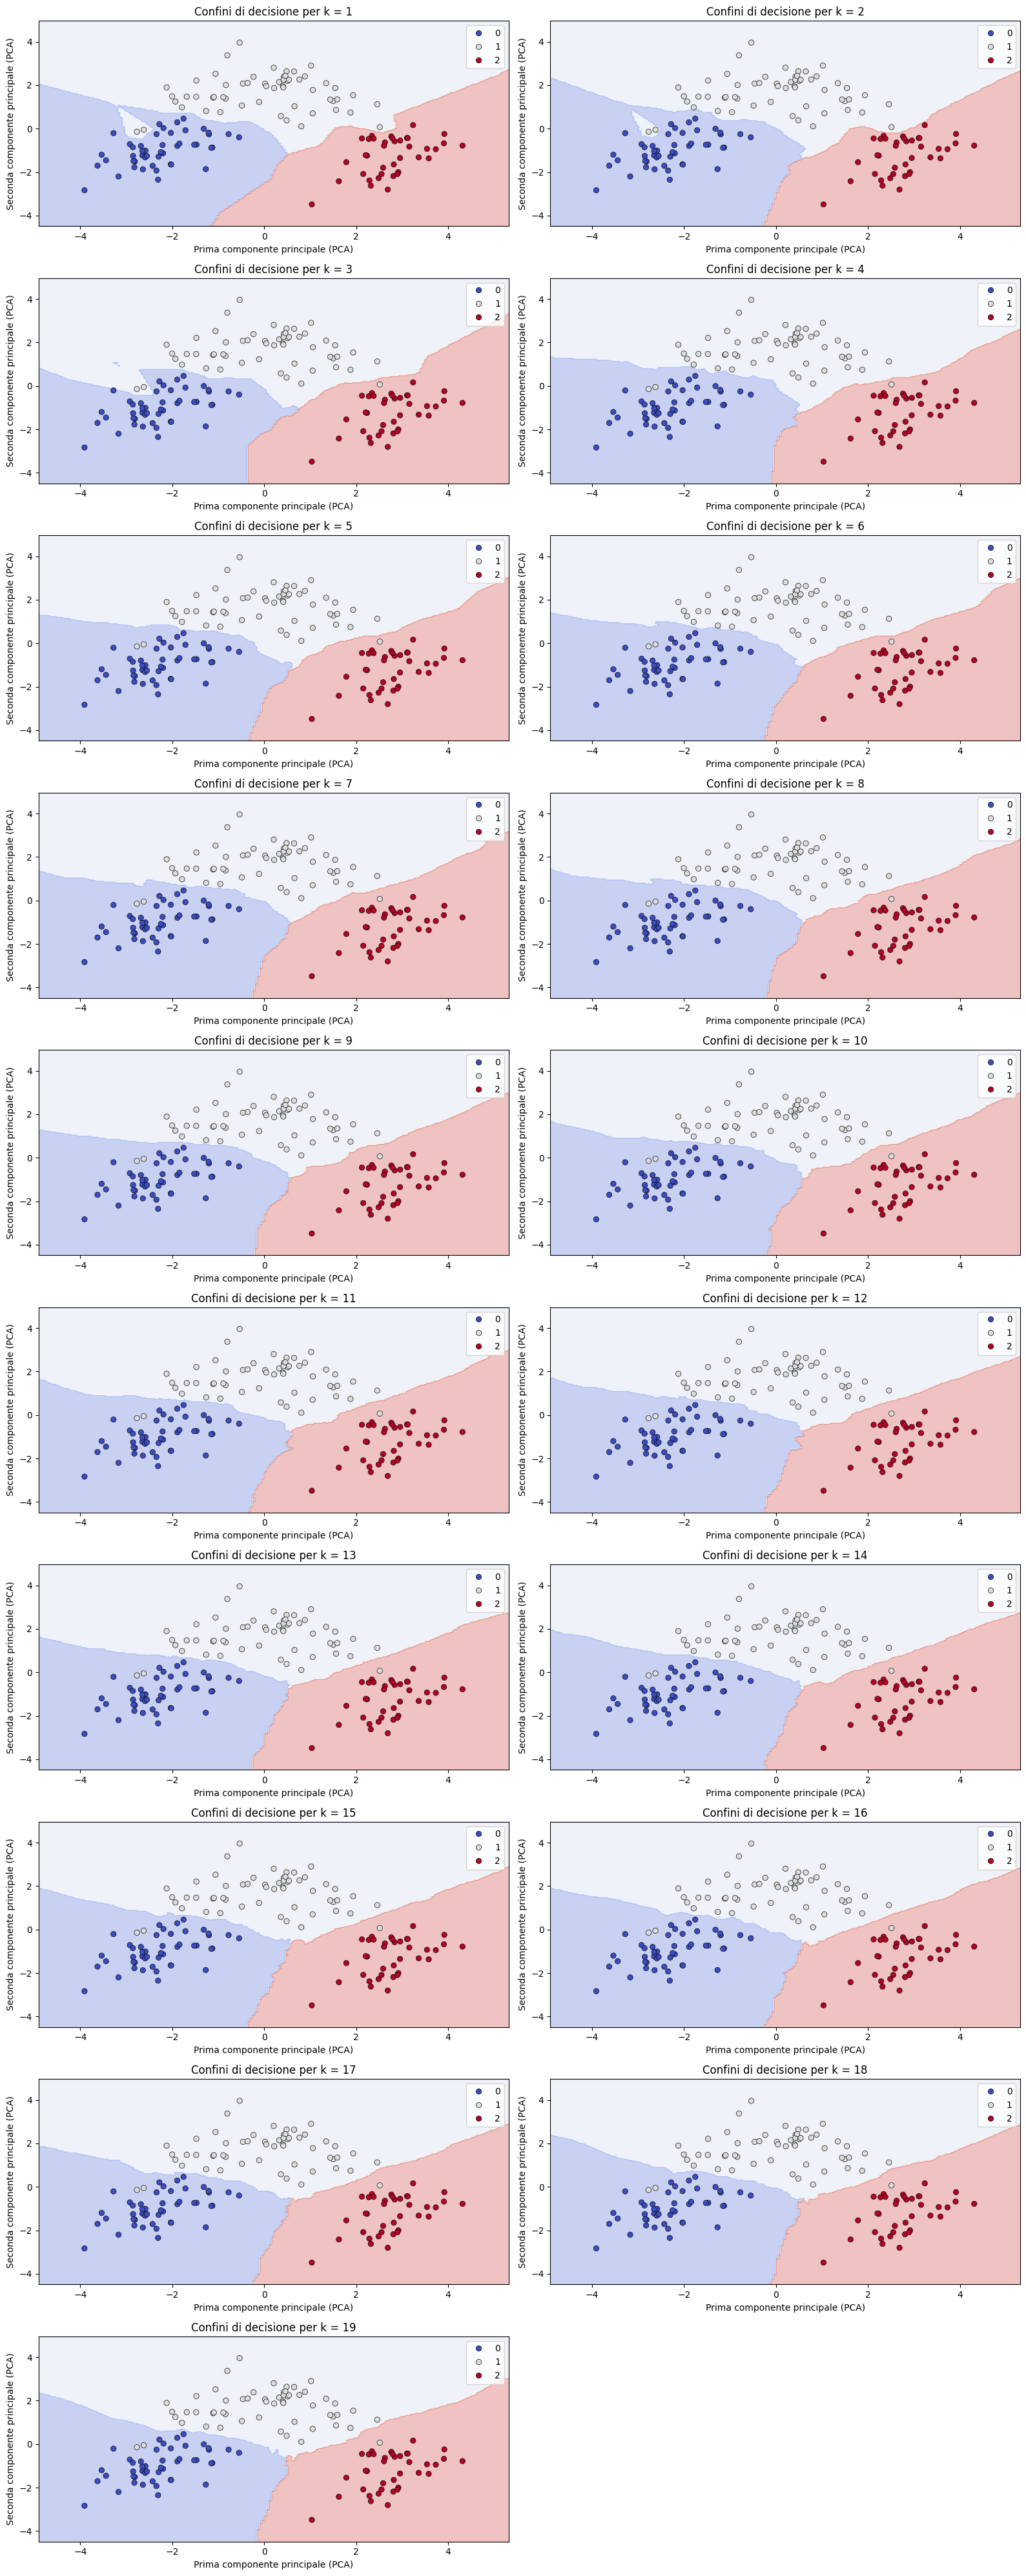

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine

# Riduzione dimensionale con PCA (prendiamo solo 2 componenti per la visualizzazione)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_ss)

# Definiamo un range di valori di k da testare
k_values = np.arange(1,20)

# Creazione della griglia di punti per disegnare i confini di decisione
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Creazione del grafico per diversi valori di k
plt.figure(figsize=(16, 40))
for i, k in enumerate(k_values, 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pca, y_train)

    # Predizione per ogni punto della griglia
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Disegno dei confini di decisione
    plt.subplot(10, 2, i)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='coolwarm', edgecolor='k')

    plt.title(f"Confini di decisione per k = {k}")
    plt.xlabel("Prima componente principale (PCA)")
    plt.ylabel("Seconda componente principale (PCA)")

plt.tight_layout()
plt.show()

In [27]:
X_pca

array([[-1.47234303, -0.73425072],
       [-2.6497094 , -1.23021145],
       [-1.88878827, -0.7924716 ],
       [-2.21115907, -0.75345768],
       [ 2.81757114, -1.64568754],
       [ 3.73165137, -0.94374515],
       [-2.00318459,  1.48866684],
       [ 2.28749052, -2.37989381],
       [-2.34494787, -1.92621606],
       [-2.58380439, -1.01010796],
       [ 0.48597588,  2.63907948],
       [ 0.6498119 ,  2.62837477],
       [-2.63950743, -1.86946018],
       [-2.0308598 , -0.1947277 ],
       [ 2.12422659, -0.44871788],
       [ 1.34665718,  2.09143679],
       [ 0.40560046,  1.95446872],
       [-1.93186592,  1.24821416],
       [-1.89218701,  0.29165108],
       [-1.31489556, -0.00547251],
       [-0.95484721,  0.75891277],
       [ 3.35973848, -1.31941369],
       [-3.53622075, -1.19764083],
       [ 2.48691428, -2.27617037],
       [ 1.03473199, -3.48245334],
       [-2.64894947, -1.02653557],
       [-3.27865538, -0.20604412],
       [ 1.93395933,  1.53857301],
       [ 0.36165946,

In [26]:
X_test

array([[1.410e+01, 2.160e+00, 2.300e+00, 1.800e+01, 1.050e+02, 2.950e+00,
        3.320e+00, 2.200e-01, 2.380e+00, 5.750e+00, 1.250e+00, 3.170e+00,
        1.510e+03],
       [1.251e+01, 1.240e+00, 2.250e+00, 1.750e+01, 8.500e+01, 2.000e+00,
        5.800e-01, 6.000e-01, 1.250e+00, 5.450e+00, 7.500e-01, 1.510e+00,
        6.500e+02],
       [1.387e+01, 1.900e+00, 2.800e+00, 1.940e+01, 1.070e+02, 2.950e+00,
        2.970e+00, 3.700e-01, 1.760e+00, 4.500e+00, 1.250e+00, 3.400e+00,
        9.150e+02],
       [1.156e+01, 2.050e+00, 3.230e+00, 2.850e+01, 1.190e+02, 3.180e+00,
        5.080e+00, 4.700e-01, 1.870e+00, 6.000e+00, 9.300e-01, 3.690e+00,
        4.650e+02],
       [1.367e+01, 1.250e+00, 1.920e+00, 1.800e+01, 9.400e+01, 2.100e+00,
        1.790e+00, 3.200e-01, 7.300e-01, 3.800e+00, 1.230e+00, 2.460e+00,
        6.300e+02],
       [1.383e+01, 1.650e+00, 2.600e+00, 1.720e+01, 9.400e+01, 2.450e+00,
        2.990e+00, 2.200e-01, 2.290e+00, 5.600e+00, 1.240e+00, 3.370e+00,
        1.26

In [28]:
pca

PCA(n_components=2)